In [1]:
import open3d as o3d
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
matplotlib.rcParams['figure.dpi'] = 150
import copy
from scipy.spatial import Delaunay
from collections import defaultdict
import random
import elkai
from functools import partial
import time
from SurfaceDivision import MorseArc, MorseD
from GeometricLocalPath import lines_arc, path_arc, lines_vertical, path_vertical
import IntervalPlanA
import IntervalPlanV

## Vertical sweeping line

### Surface division

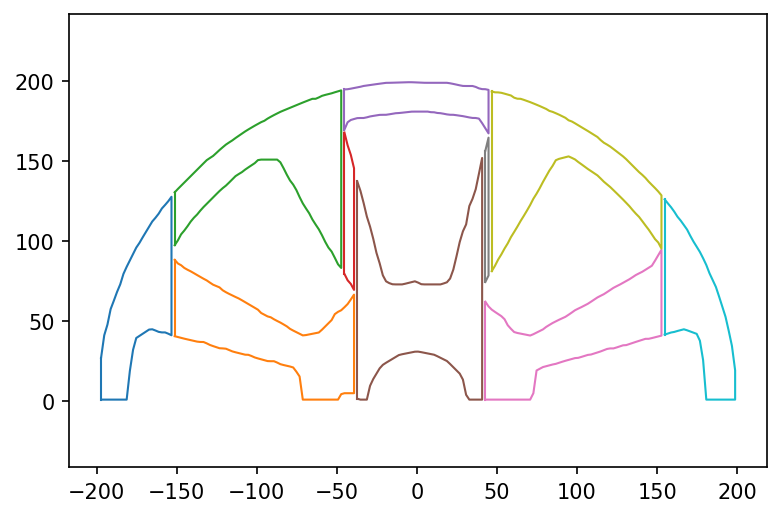

In [5]:
# replace with your own model
pcd = o3d.io.read_point_cloud("Wheel_upper_surface.PLY")
pcd.normalize_normals()
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=100, origin=[0,0,0])
points = np.asarray(pcd.points)
normals = np.asarray(pcd.normals)
new_tri_set = np.load('new_tri_set.npy')

# contour
final_contour = np.load('final_contour.npy',allow_pickle= True)
final_contour = list(final_contour)
points_yz = points[:,:2]
# plt.triplot(points_yz[:,0],points_yz[:,1],new_tri_set)
final_contour_points = []
for i in range(len(final_contour)):
    x = [points_yz[j][0] for j in final_contour[i]]
    y = [points_yz[j][1] for j in final_contour[i]]
    final_contour_points.append([x,y])
#     plt.plot(x,y,color = 'k')
# plt.axis('equal')
# plt.show()

# boundary and spacing between sweeping lines
step = 2
ymin = np.min(points_yz[:,0])
ymax = np.max(points_yz[:,1])
contour_bounds = []
for i in range(len(final_contour_points)):
    contour_bounds.append([np.min(final_contour_points[i][0]),np.max(final_contour_points[i][0]),np.min(final_contour_points[i][1]),np.max(final_contour_points[i][1])])

# Surface Division
new_sets, new_link = MorseD(final_contour_points, contour_bounds, [ymin, ymax], step)

# plot
color = []
for i in range(len(new_sets)):
    p = plt.plot(new_sets[i][0]+new_sets[i][0][::-1],new_sets[i][1]+new_sets[i][2][::-1],linewidth = 1)
    color.append(p[0].get_color())
    plt.plot([new_sets[i][0][0],new_sets[i][0][0]],[new_sets[i][1][0],new_sets[i][2][0]],color = color[-1],linewidth = 1)
plt.axis('equal')
plt.show()

### Geometric local path

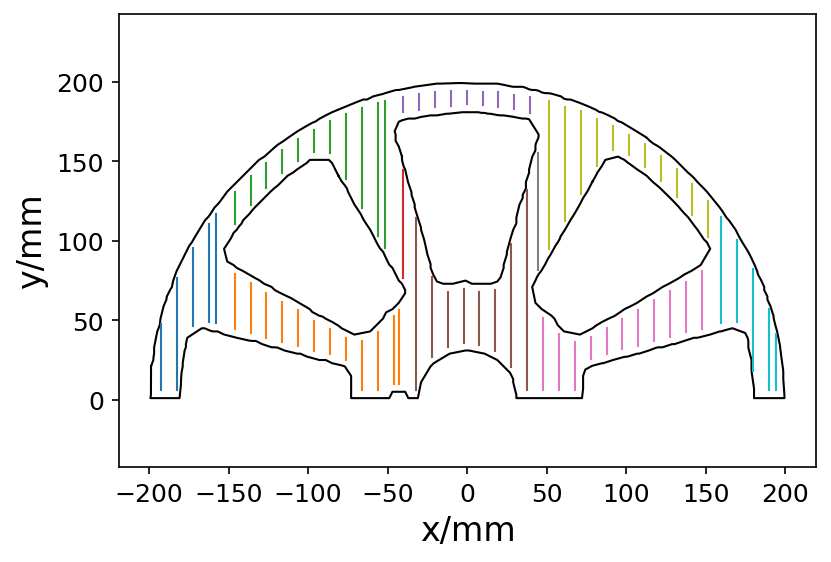

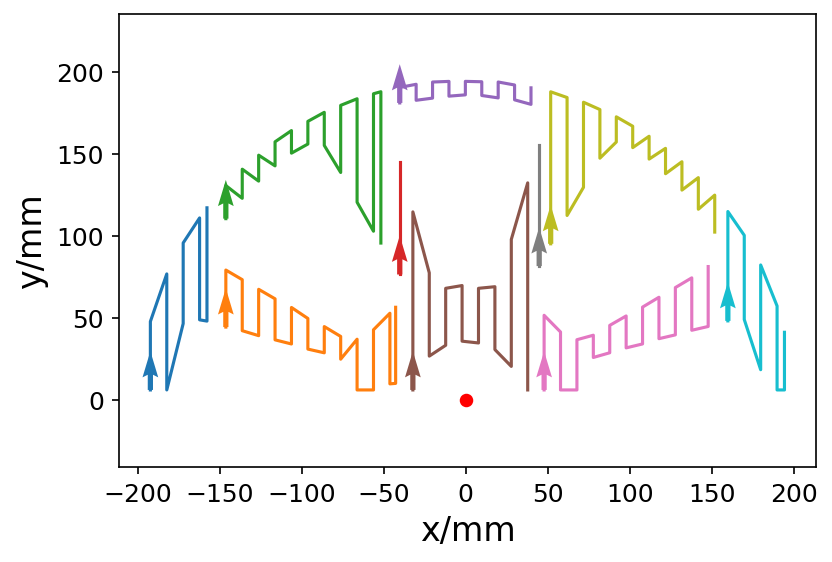

In [22]:
# line
radius_of_tool = 5
line_set = lines_vertical(new_sets,radius_of_tool)
# plot
for i in range(len(final_contour)):
    x, y = final_contour_points[i]
    plt.plot(x,y,color = 'k',linewidth = 1)
plt.axis('equal')

n=30
for i in range(len(line_set)):
    for j in range(int(len(line_set[i][0])/2)):
        ty = [line_set[i][0][2*j], line_set[i][0][2*j+1]]
        tz = [line_set[i][1][2*j], line_set[i][1][2*j+1]]
        plt.plot(ty,tz, color = color[i], linewidth = 1)
plt.xlabel('x/mm',fontsize=16)
plt.ylabel('y/mm',fontsize=16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

initial_point = [0,0]
plt.scatter(initial_point[0],initial_point[1],s = 30,c = 'r')

for i in range(len(line_set)):
    path, l, sf = path_vertical(line_set[i])
    y, z = path
    plt.quiver(y[0],z[0],y[1]-y[0],z[1]-z[0],angles='xy', scale_units='xy',color=color[i])
    plt.plot(y,z,color = color[i])
#     plt.scatter(y[0],z[0],s=30,color = 'r',edgecolors='r')
#     plt.scatter(y[-1],z[-1],s=30,color = 'b',edgecolors='b')

plt.axis('equal')
plt.xlabel('x/mm',fontsize=16)
plt.ylabel('y/mm',fontsize=16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### Total path
- Directly connect the local paths
- Connect local paths based on the order calculated by solving TSP


Initial: length =  867.6207324598839


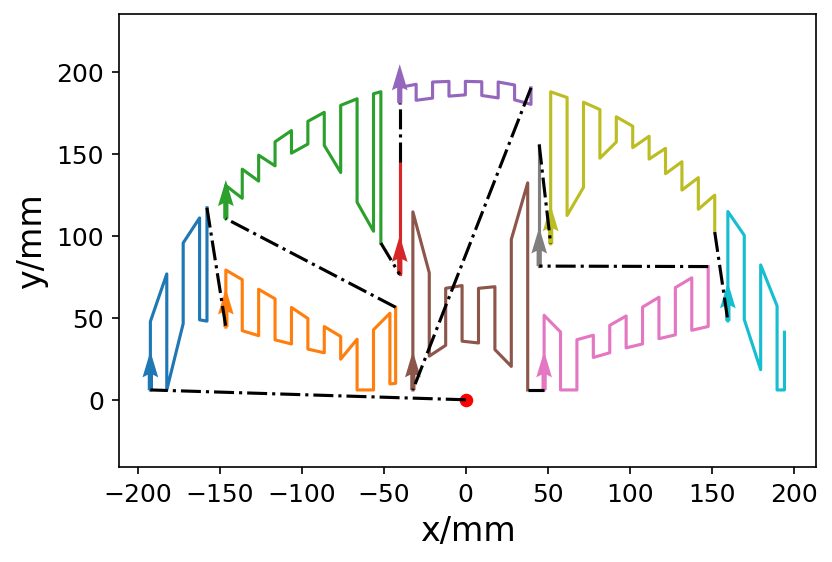

After TSP: length =  747.0357594953247


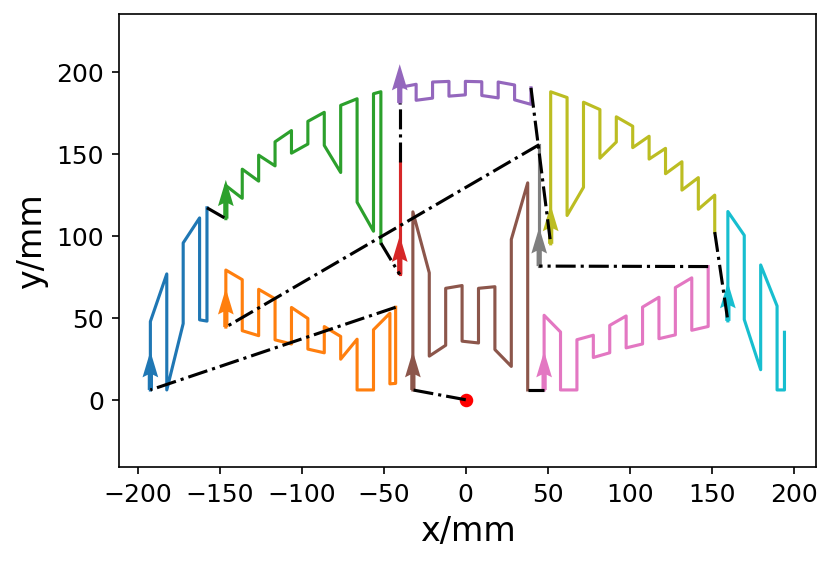

In [23]:
initial_point = [0,0]
plt.scatter(initial_point[0],initial_point[1],s = 30,c = 'r')
path_set = []
path_l_set = []
path_sf_set = []

for i in range(len(line_set)):
    path, l, sf = path_vertical(line_set[i])
    path_set.append(path)
    path_l_set.append(l)
    path_sf_set.append(sf)
    y, z = path
    plt.quiver(y[0],z[0],y[1]-y[0],z[1]-z[0],angles='xy', scale_units='xy',color=color[i])
    plt.plot(y,z,color = color[i])
#     plt.scatter(y[0],z[0],s=30,color = 'r',edgecolors='r')
#     plt.scatter(y[-1],z[-1],s=30,color = 'b',edgecolors='b')

path_order = [i for i in range(len(path_set)+1)]

l = 0

for i in range(len(path_order)-1):
    if i == 0:
        l += np.linalg.norm(np.asarray(initial_point)-np.asarray(path_sf_set[path_order[i+1]-1][0]))
        plt.plot([initial_point[0],path_sf_set[path_order[i+1]-1][0][0]],[initial_point[0],path_sf_set[path_order[i+1]-1][0][1]],'k-.')
    else:
        l += np.linalg.norm(np.asarray(path_sf_set[path_order[i+1]-1][0])-np.asarray(path_sf_set[path_order[i]-1][1]))
        plt.plot([path_sf_set[path_order[i]-1][1][0],path_sf_set[path_order[i+1]-1][0][0]],[path_sf_set[path_order[i]-1][1][1],path_sf_set[path_order[i+1]-1][0][1]],'k-.')

print('Initial: length = ',l)
plt.axis('equal')
plt.xlabel('x/mm',fontsize=16)
plt.ylabel('y/mm',fontsize=16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

initial_point = [0,0]
plt.scatter(initial_point[0],initial_point[1],s = 30,c = 'r')
path_set = []
path_l_set = []
path_sf_set = []

for i in range(len(line_set)):
    path, l, sf = path_vertical(line_set[i])
    path_set.append(path)
    path_l_set.append(l)
    path_sf_set.append(sf)
    y, z = path
    plt.quiver(y[0],z[0],y[1]-y[0],z[1]-z[0],angles='xy', scale_units='xy',color=color[i])
    plt.plot(y,z,color = color[i])
#     plt.scatter(y[0],z[0],s=30,color = 'r',edgecolors='r')
#     plt.scatter(y[-1],z[-1],s=30,color = 'b',edgecolors='b')

(TL_tsp, path_order, T_path_tsp) = IntervalPlanV.tsp_path(initial_point, path_set, path_l_set, path_sf_set)

for i in range(len(path_order)-1):
    if i == 0:
        plt.plot([initial_point[0],path_sf_set[path_order[i+1]-1][0][0]],[initial_point[0],path_sf_set[path_order[i+1]-1][0][1]],'k-.')
    else:
        plt.plot([path_sf_set[path_order[i]-1][1][0],path_sf_set[path_order[i+1]-1][0][0]],[path_sf_set[path_order[i]-1][1][1],path_sf_set[path_order[i+1]-1][0][1]],'k-.')

print('After TSP: length = ',TL_tsp)

plt.axis('equal')
plt.xlabel('x/mm',fontsize=16)
plt.ylabel('y/mm',fontsize=16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### Total path
- Connect local paths based on the results of interval planning

time: 6.3809802532196045
path length: 304.1075879634963
max pop: [2, 0, 2, 0, 2, 1, 1, 2, 2, 3]


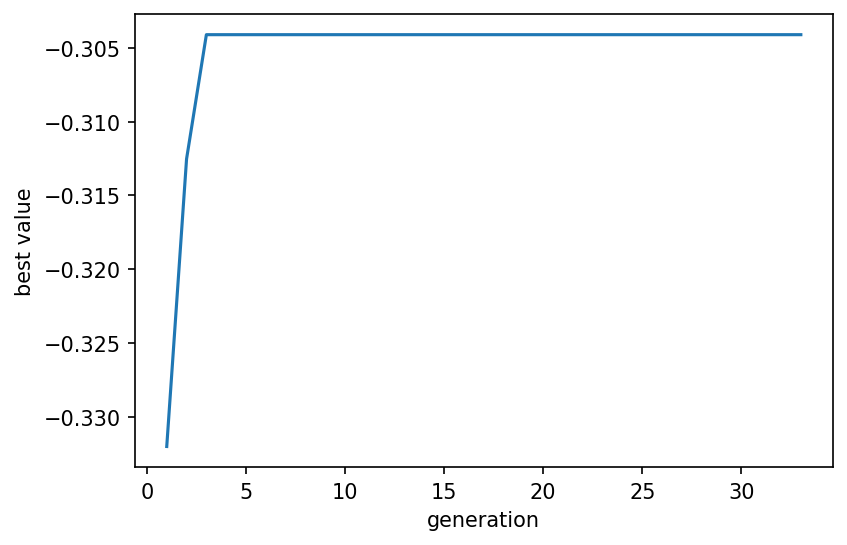

In [14]:
# GA tsp
pt = time.time()
initial_point = [0,0]
tf = partial(IntervalPlanV.ga_tsp_path,initial_point = initial_point, line_set = line_set)
gaaa = IntervalPlanV.GA_path(tf,30,[len(line_set),4],crossover_rate = 0.8, mutation_rate = 0.1)
max_value, max_value_his, max_pop = gaaa.iteration(100, end_loop = 30)
print('time:',time.time()-pt)
fig,ax = plt.subplots()
ax.plot(np.arange(len(max_value_his))+1, max_value_his)
print('path length:',-max_value*1000)
print('max pop:',max_pop)
plt.xlabel('generation')
plt.ylabel('best value')
plt.show()

After interval planning: length = : 304.1075879634963


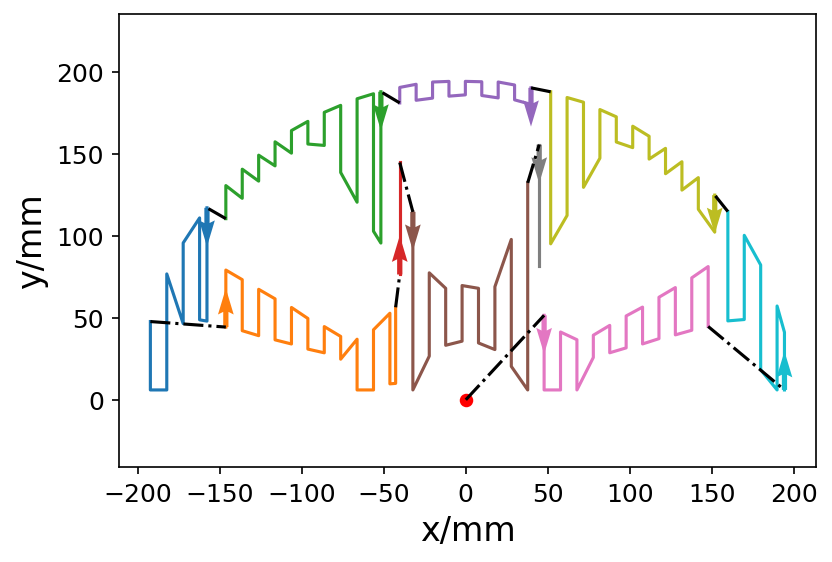

In [19]:
# plot
initial_point = [0,0]
plt.scatter(initial_point[0],initial_point[1],s = 30,c = 'r')
path_set = []
path_l_set = []
path_sf_set = []
max_pop = [2, 0, 2, 0, 2, 1, 1, 2, 2, 3] # the result from GA may not be the optimum. There exsits randomness.
for i in range(len(max_pop)):
    [new_path, l, sf ] = path_vertical(line_set[i], flag = max_pop[i]+1)
    path_set.append(new_path)
    path_l_set.append(l)
    path_sf_set.append(sf)
    y, z = new_path
    plt.quiver(y[0],z[0],y[1]-y[0],z[1]-z[0],angles='xy', scale_units='xy',color=color[i])
    plt.plot(y,z,color = color[i])
    
(TL_tsp, path_order, T_path_tsp) = IntervalPlanV.tsp_path(initial_point, path_set, path_l_set, path_sf_set)
for i in range(len(path_order)-1):
    if i == 0:
        plt.plot([initial_point[0],path_sf_set[path_order[i+1]-1][0][0]],[initial_point[0],path_sf_set[path_order[i+1]-1][0][1]],'k-.')
    else:
        plt.plot([path_sf_set[path_order[i]-1][1][0],path_sf_set[path_order[i+1]-1][0][0]],[path_sf_set[path_order[i]-1][1][1],path_sf_set[path_order[i+1]-1][0][1]],'k-.')
print('After interval planning: length = :',TL_tsp)
plt.axis('equal')
plt.xlabel('x/mm',fontsize=16)
plt.ylabel('y/mm',fontsize=16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### Lift & Interpolation
#### Lift
The tool should be lifted once,
- if the path intersects with boundaries
- if the distance in the radial direction between two adjacent path is bigger than radius of tool $r$

Blue lines mean the working path. Yellow lines mean the non-working lines (the path of the tool when lifted).

#### Interpolation
- Interpolation is needed in order to fit the curved surface.

In [20]:
def segment_cross(segment1, segment2):
    # segment 1/2: 2x2 np.array 
    # segment[i,:] means ith point [x,y]
    p1 = segment1[0,:]
    p2 = segment1[1,:]
    q1 = segment2[0,:]
    q2 = segment2[1,:]
    v1 = np.asarray(p2-p1)
    v2 = np.asarray(q1-p1)
    v3 = np.asarray(q2-p1)
    w1 = np.asarray(q2-q1)
    w2 = np.asarray(p1-q1)
    w3 = np.asarray(p2-q1)
    if np.cross(v1,v2) == 0 and np.cross(v1,v3) == 0:
        if np.linalg.norm(v1) == 0 and np.linalg.norm(w1) == 0:
            if p1[0] == q1[0] and p1[1] == q1[1]:
                return True
            else:
                return False
        else:
            if np.linalg.norm(v1) > 0:
                ip1 = 0
                ip2 = np.linalg.norm(v1)
                iq1 = np.dot(v1,v2)
                iq2 = np.dot(v1,v3)
            else:
                iq1 = 0
                iq2 = np.linalg.norm(w1)
                ip1 = np.dot(w1,w2)
                ip2 = np.dot(w1,w3)
            ipmin = np.min([ip1,ip2])
            ipmax = np.max([ip1,ip2])
            iqmin = np.min([iq1,iq2])
            iqmax = np.max([iq1,iq2])
            if ipmin < iqmin:
                if ipmax >= iqmin:
                    return True
            else:
                if iqmax >= ipmin:
                    return True
                
            return False
    elif np.sign(np.cross(v1,v2)) * np.sign(np.cross(v1,v3)) <= 0 and np.sign(np.cross(w1,w2)) * np.sign(np.cross(w1,w3)) <= 0 :
        return True
    else:
        return False

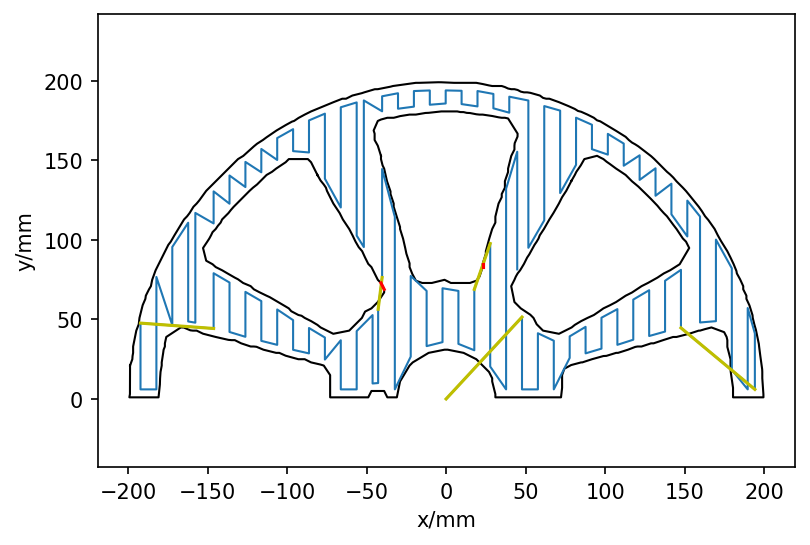

Total L: 3832.5438240799836 interval L: 304.1075879634963 lift times: 5
path order: [0, 7, 10, 9, 5, 3, 1, 2, 4, 6, 8]


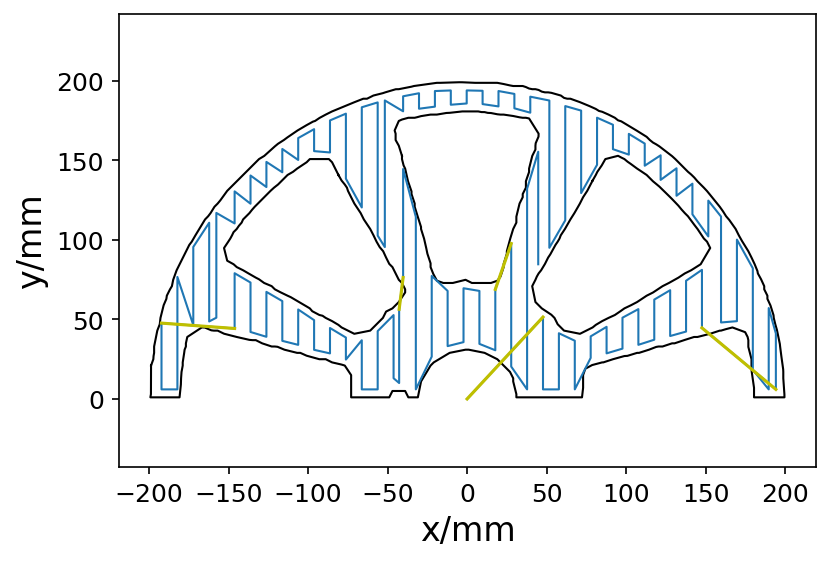

In [21]:
for i in range(len(final_contour)):
    x, y = final_contour_points[i]
    plt.plot(x,y,color = 'k',linewidth = 1)
plt.axis('equal')

plt.plot(T_path_tsp[0],T_path_tsp[1],linewidth = 1)
count = 0
lift_index = []
for i in range(len(T_path_tsp[0])-1):
    segment1 = np.asarray([[T_path_tsp[0][i],T_path_tsp[1][i]],[T_path_tsp[0][i+1],T_path_tsp[1][i+1]]])
    if abs(segment1[0,0]- segment1[1,0]) > 3*radius_of_tool:
        count += 1
        lift_index.append(i)
        plt.plot(segment1[:,0],segment1[:,1],'y',linewidth = 1.5)
    else:
        for j in range(len(final_contour_points)):
            for k in range(len(final_contour_points[j][0])-1):
                segment2 = np.asarray([[final_contour_points[j][0][k],final_contour_points[j][1][k]],[final_contour_points[j][0][k+1],final_contour_points[j][1][k+1]]])
                if segment_cross(segment1, segment2):
                    count += 1
                    lift_index.append(i)
                    plt.plot(segment1[:,0],segment1[:,1],'y',linewidth = 1.5)
                    plt.plot(segment2[:,0],segment2[:,1],'r',linewidth = 1.5)
                    break
plt.xlabel('x/mm')
plt.ylabel('y/mm')
plt.show()

# Total Length
Total_L = 0
for i in range(len(T_path_tsp[0])-1):
    segment = np.asarray([[T_path_tsp[0][i],T_path_tsp[1][i]],[T_path_tsp[0][i+1],T_path_tsp[1][i+1]]])
    Total_L += np.linalg.norm(segment[0,:] - segment[1,:])
    
print('Total L:', Total_L, 'interval L:', TL_tsp,'lift times:',count) 
print('path order:', path_order)

# Interpolation
path_space = 3 # space between two interpolated points
interpolated_path = [[],[]]
y, z = T_path_tsp
interpolated_lift_index = []
for i in range(len(y)-1):
    if i not in lift_index:
        p1 = np.asarray([y[i],z[i]])
        p2 = np.asarray([y[i+1],z[i+1]])
        l = np.linalg.norm(p1-p2)
        n = int(l / path_space)
        if n !=0:
            ty = np.linspace(p1[0],p2[0],n)
            tz = np.linspace(p1[1],p2[1],n)
            ty = np.delete(ty,-1)
            tz = np.delete(tz,-1)
        else:
            ty = [p1[0]]
            tz = [p1[1]]
    else:
        interpolated_lift_index.append(len(interpolated_path[0]))
        ty = [y[i],y[i+1]]
        tz = [z[i],z[i+1]]
    interpolated_path[0].extend(ty)
    interpolated_path[1].extend(tz)

for i in range(len(final_contour)):
    x, y = final_contour_points[i]
    plt.plot(x,y,color = 'k',linewidth = 1)
plt.axis('equal')
plt.xlabel('x/mm',fontsize=16)
plt.ylabel('y/mm',fontsize=16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.plot(interpolated_path[0],interpolated_path[1],linewidth = 1)
for i in interpolated_lift_index:
    plt.plot(interpolated_path[0][i:i+2],interpolated_path[1][i:i+2],'y',linewidth = 1.5)
    


## Arcual sweeping line
The main idea is the same.

### Surface division

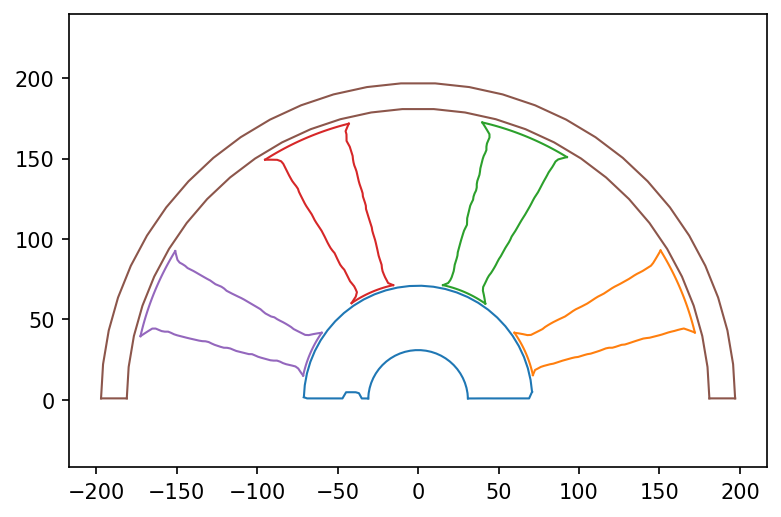

In [30]:
#import model
pcd = o3d.io.read_point_cloud("Wheel_upper_surface.ply")
pcd.normalize_normals()
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=100, origin=[0,0,0])
points = np.asarray(pcd.points)
normals = np.asarray(pcd.normals)
new_tri_set = np.load('new_tri_set.npy')

# tri_set after alpha_shape
final_contour = np.load('final_contour.npy',allow_pickle= True)

# plot the contour
final_contour = list(final_contour)
points_yz = points[:,:2]
# plt.triplot(points_yz[:,0],points_yz[:,1],new_tri_set)
final_contour_points = []
for i in range(len(final_contour)):
    x = [points_yz[j][0] for j in final_contour[i]]
    y = [points_yz[j][1] for j in final_contour[i]]
    final_contour_points.append([x,y])
#     plt.plot(x,y,color = 'k')
# plt.axis('equal')
# plt.show()

# convert the cartesian system into polar system
bound_y = [np.min(points_yz[:,0]), np.max(points_yz[:,0])]
bound_z = [np.min(points_yz[:,1]), np.max(points_yz[:,1])]
center = np.asarray([0,0])
final_contour_points_polar = []
contour_bounds_polar = []
for i in range(len(final_contour)):
    r = [np.linalg.norm(points_yz[index,:] - center) for index in final_contour[i]]
    theta = [np.arctan2((points_yz[index,:] - center)[1],(points_yz[index,:] - center)[0]) for index in final_contour[i]]
    final_contour_points_polar.append([r,theta])
    contour_bounds_polar.append([np.min(r),np.max(r),np.min(theta),np.max(theta)])

# calculate the boundary
ta = np.asarray(contour_bounds_polar)
r_min = np.min(ta[:,0])
r_max = np.max(ta[:,1])

# Surface Division
sets= MorseArc(final_contour_points_polar, contour_bounds_polar, [r_min,r_max], 2)
n_sets = len(sets)
for i in range(n_sets):
    if len(sets[n_sets-1-i][0]) <= 1:
        sets.pop(n_sets-1-i)

# plot 
n=30
for i in range(len(sets)):
    y1 = [center[0]+sets[i][0][index]*np.cos(sets[i][1][index]) for index in range(len(sets[i][0]))]
    z1 = [center[1]+sets[i][0][index]*np.sin(sets[i][1][index]) for index in range(len(sets[i][0]))]
    y2 = [center[0]+sets[i][0][index]*np.cos(sets[i][2][index]) for index in range(len(sets[i][0]))]
    z2 = [center[1]+sets[i][0][index]*np.sin(sets[i][2][index]) for index in range(len(sets[i][0]))]
#     plt.scatter(y1+y2,z1+z2,s = 5, color = color)
    p = plt.plot(y1,z1,linewidth = 1)
    color = p[0].get_color()
    plt.plot(y2,z2,linewidth = 1,color = color)
    r1 = sets[i][0][0]
    r2 = sets[i][0][-1]
    theta1i = sets[i][1][0]
    theta1a = sets[i][2][0]
    theta2i = sets[i][1][-1]
    theta2a = sets[i][2][-1]
    if theta1a < theta1i:
        theta1a += np.pi*2
    if theta2a < theta2i:
        theta2a += np.pi*2
    angle1 = np.linspace(theta1i,theta1a,n)
    angle2 = np.linspace(theta2i,theta2a,n)
    arc1 = [center[0]+r1*np.cos(angle1),center[1]+r1*np.sin(angle1)]
    arc2 = [center[0]+r2*np.cos(angle2),center[1]+r2*np.sin(angle2)]
    plt.plot(arc1[0], arc1[1], color = color, linewidth = 1)
    plt.plot(arc2[0], arc2[1], color = color, linewidth = 1)
        
plt.axis('equal')
plt.show()

### Geometric local path

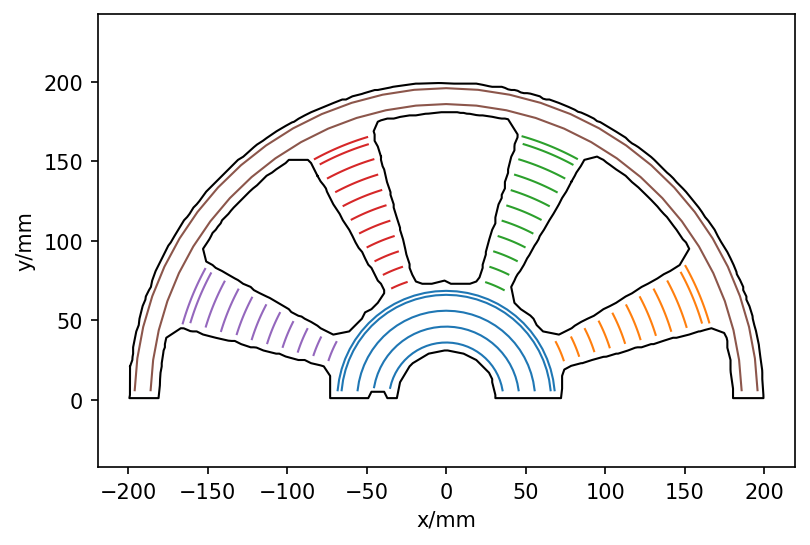

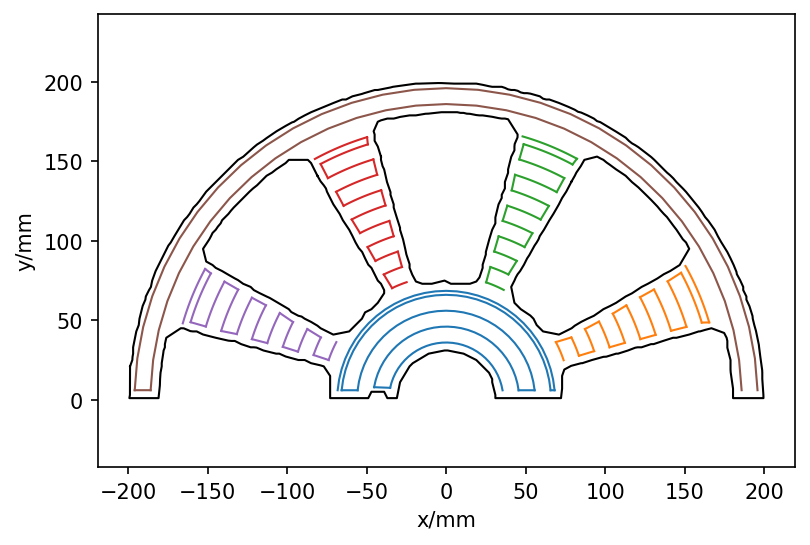

In [24]:
# set the radius of the tool is 5. And assume the path width is 2*radius_of_tool.
radius_of_tool = 5
line_set = lines_arc(sets, radius_of_tool)

# plot the lines
for i in range(len(final_contour)):
    x, y = final_contour_points[i]
    plt.plot(x,y,color = 'k',linewidth = 1)
plt.axis('equal')
color = []
n=30
for i in range(len(line_set)):
    for j in range(int(len(line_set[i][0])/2)):
        r = line_set[i][0][2*j]
        theta1 = line_set[i][1][2*j]
        theta2 = line_set[i][1][2*j+1]
        if theta2 - theta1 != 0:
            if theta1 > theta2:
                theta2 += np.pi*2
            angle = np.arange(theta1,theta2+(theta2-theta1)/(n+1), (theta2-theta1)/n)
        else:
            angle = theta1
        arc = [center[0]+r*np.cos(angle),center[1]+r*np.sin(angle)]
        if j == 0 :
            p = plt.plot(arc[0], arc[1], linewidth = 1)
            color.append(p[0].get_color())
        else:
            p = plt.plot(arc[0], arc[1], color = color[-1], linewidth = 1)
plt.xlabel('x/mm')
plt.ylabel('y/mm')
plt.show()

# plot the continuous path in each subsurface
for i in range(len(final_contour)):
    x, y = final_contour_points[i]
    plt.plot(x,y,color = 'k',linewidth = 1)
plt.axis('equal')

n=30
for i in range(len(line_set)):
    [new_path, l, sf, clock ] = path_arc(line_set[i])
    r, theta = new_path
    pre_point = None
    for j in range(int(len(r)/2)):
        index = 2*j
        tr = r[index]
        theta1 = theta[index]
        theta2 = theta[index+1]
        if clock[index] == 1:
            if theta2 - theta1 != 0:
                if theta1 > theta2:
                    theta2 += np.pi*2
                angle = np.arange(theta1,theta2+(theta2-theta1)/(n+1), (theta2-theta1)/n)
            else:
                angle = theta1
        elif clock[index] == -1:
            if theta2 - theta1 != 0:
                if theta1 < theta2:
                    theta2 -= np.pi*2
                angle = np.arange(theta1,theta2+(theta2-theta1)/(n+1), (theta2-theta1)/n)
            else:
                angle = theta1
        arc = [center[0]+tr*np.cos(angle),center[1]+tr*np.sin(angle)]
        plt.plot(arc[0], arc[1], color = color[i], linewidth = 1)
        cur_point_s = np.asarray([tr*np.cos(theta1), tr*np.sin(theta1)])
        cur_point_f = np.asarray([tr*np.cos(theta2), tr*np.sin(theta2)])
        if pre_point is not None:
            plt.plot([pre_point[0], cur_point_s[0]], [pre_point[1], cur_point_s[1]], color = color[i], linewidth = 1)
        pre_point = cur_point_f
        
plt.xlabel('x/mm')
plt.ylabel('y/mm')
plt.show()

### Interval planning

time: 14.782502174377441
path length: 1.1899483672458337
max pop: [0, 1, 2, 2, 1, 0]


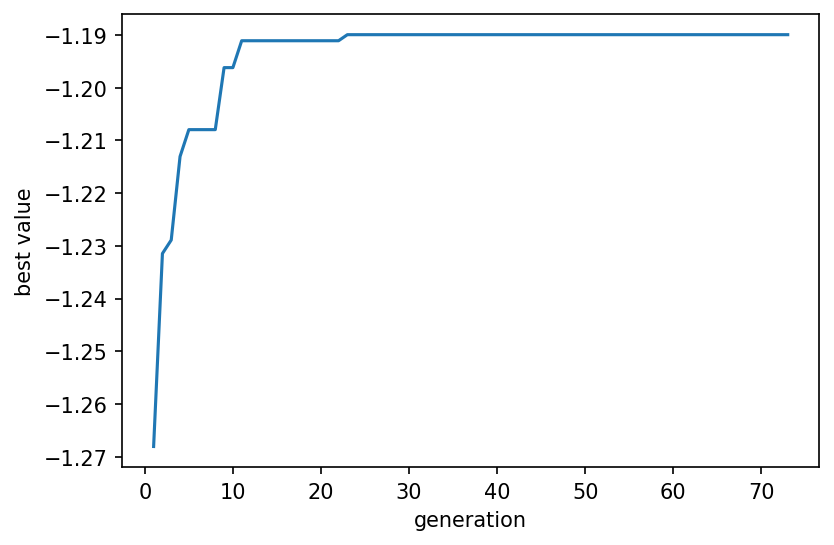

In [25]:
# GA tsp.
# the fitness value = length of total path/10000

pt = time.time()
initial_point = [0,0]
tf = partial(IntervalPlanA.ga_tsp_path,initial_point = initial_point, line_set = line_set)
gaaa = IntervalPlanA.GA_path(tf,50,[len(line_set),4],crossover_rate = 0.8, mutation_rate = 0.1)
max_value, max_value_his, max_pop = gaaa.iteration(100, end_loop = 50)
print('time:',time.time()-pt)
fig,ax = plt.subplots()
ax.plot(np.arange(len(max_value_his))+1, max_value_his)
plt.xlabel('generation')
plt.ylabel('best value')
print('path length:',-max_value)
print('max pop:',max_pop)
plt.show()

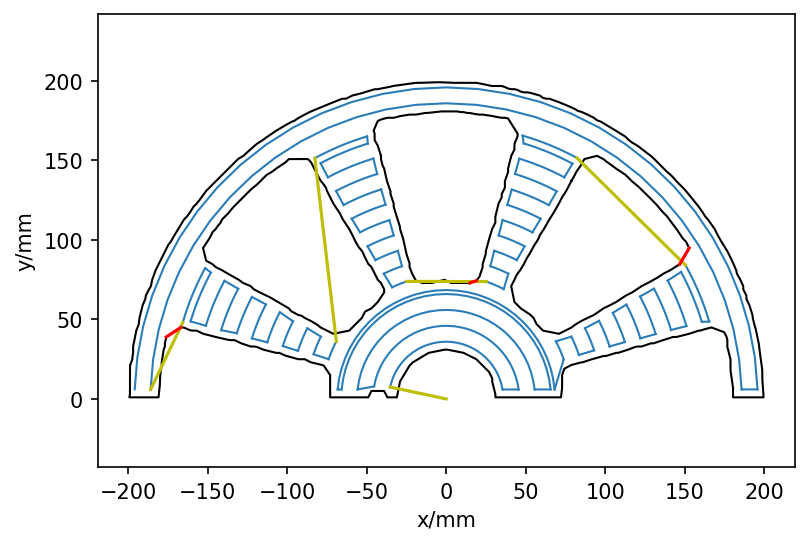

TL: 1190.3679699777165
Total L: 4575.175927650189 interval L: 1190.3679699777165 lift times: 5
path order: [0, 1, 2, 3, 4, 5, 6]


In [27]:
path_set = []
path_l_set = []
path_sf_set = []
clock_set = []
initial_point = [0,0]
max_pop = [1, 0, 3, 0, 0, 1]
for i in range(len(line_set)):
    [new_path, l, sf, clock ] = path_arc(line_set[i], flag = max_pop[i]+1)
    path_set.append(new_path)
    path_l_set.append(l)
    path_sf_set.append(sf)
    clock_set.append(clock)

(TL_tsp, path_order, T_path_tsp, T_clock_tsp) = IntervalPlanA.tsp_path(initial_point, path_set, path_l_set, path_sf_set, clock_set)

for i in range(len(final_contour)):
    x, y = final_contour_points[i]
    plt.plot(x,y,color = 'k',linewidth = 1)
plt.axis('equal')

n=30
color = (42/255,125/255,184/255)
r, theta = T_path_tsp
for index in range(len(r)-1):
    tr1 = r[index]
    tr2 = r[index+1]
    theta1 = theta[index]
    theta2 = theta[index+1]
    if T_clock_tsp[index] == 0:
        plt.plot([tr1*np.cos(theta1), tr2*np.cos(theta2)], [tr1*np.sin(theta1), tr2*np.sin(theta2)], color = color, linewidth = 1)
    else:
        if T_clock_tsp[index] == 1:
            if theta2 - theta1 != 0:
                if theta1 > theta2:
                    theta2 += np.pi*2
                angle = np.arange(theta1,theta2+(theta2-theta1)/(n+1), (theta2-theta1)/n)
            else:
                angle = theta1
        elif T_clock_tsp[index] == -1:
            if theta2 - theta1 != 0:
                if theta1 < theta2:
                    theta2 -= np.pi*2
                angle = np.arange(theta1,theta2+(theta2-theta1)/(n+1), (theta2-theta1)/n)
            else:
                angle = theta1
        arc = [center[0]+tr1*np.cos(angle),center[1]+tr1*np.sin(angle)]
        plt.plot(arc[0], arc[1], color = color, linewidth = 1)

count = 0
lift_index = []
for i in range(len(T_path_tsp[0])-1):
    if T_clock_tsp[i] == 0:
        segment1_polar = np.asarray([[T_path_tsp[0][i],T_path_tsp[1][i]],[T_path_tsp[0][i+1],T_path_tsp[1][i+1]]])
        segment1 = np.asarray([[segment1_polar[0,0]*np.cos(segment1_polar[0,1]),segment1_polar[0,0]*np.sin(segment1_polar[0,1])],[segment1_polar[1,0]*np.cos(segment1_polar[1,1]),segment1_polar[1,0]*np.sin(segment1_polar[1,1])]])
        if abs(segment1_polar[0,0]- segment1_polar[1,0]) > 3*radius_of_tool:
            count += 1
            lift_index.append(i)
            plt.plot(segment1[:,0],segment1[:,1],'y',linewidth = 1.5)
        else:
            for j in range(len(final_contour_points)):
                for k in range(len(final_contour_points[j][0])-1):
                    segment2 = np.asarray([[final_contour_points[j][0][k],final_contour_points[j][1][k]],[final_contour_points[j][0][k+1],final_contour_points[j][1][k+1]]])
                    if segment_cross(segment1, segment2):
                        count += 1
                        lift_index.append(i)
                        plt.plot(segment1[:,0],segment1[:,1],'y',linewidth = 1.5)
                        plt.plot(segment2[:,0],segment2[:,1],'r',linewidth = 1.5)
                        break
plt.axis('equal')
plt.xlabel('x/mm')
plt.ylabel('y/mm')
        
plt.show()
print('TL:',TL_tsp)

#50
print('Total L:', TL_tsp+np.sum(path_l_set),'interval L:', TL_tsp,'lift times:',count) # 62 - 32 = 30
print('path order:', path_order)


### Interpolation

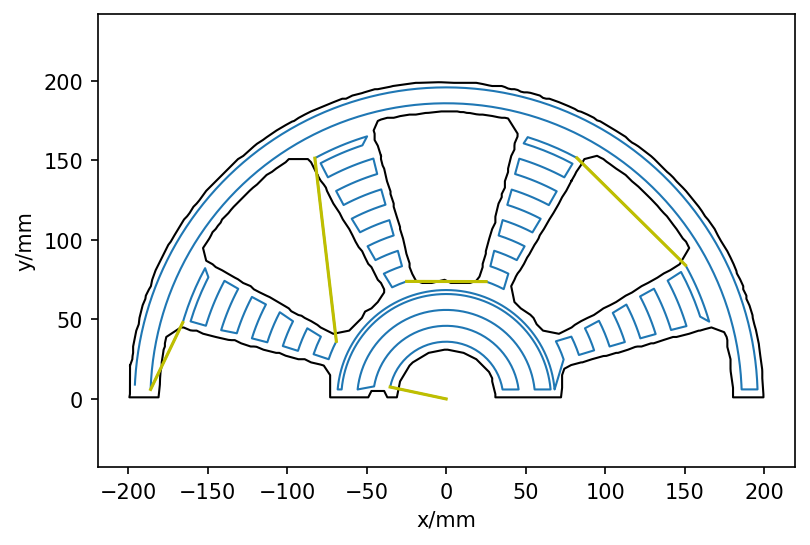

In [28]:
path_space = 3 # space between two interpolated points

interpolated_path = [[],[]]
r, theta = T_path_tsp
interpolated_lift_index = []
for i in range(len(r)-1):
    if i not in lift_index:
        if T_clock_tsp[i] == 0:
            p1 = np.asarray([r[i]*np.cos(theta[i]),r[i]*np.sin(theta[i])])
            p2 = np.asarray([r[i+1]*np.cos(theta[i+1]),r[i+1]*np.sin(theta[i+1])])
            l = np.linalg.norm(p1-p2)
            n = int(l / path_space)
            if n !=0:
                ty = np.linspace(p1[0],p2[0],n)
                tz = np.linspace(p1[1],p2[1],n)
                ty = np.delete(ty,-1)
                tz = np.delete(tz,-1)
            else:
                ty = [p1[0]]
                tz = [p1[1]]
            interpolated_path[0].extend(ty)
            interpolated_path[1].extend(tz)
        else:
            tr1 = r[i]
            tr2 = r[i+1]
            theta1 = theta[i]
            theta2 = theta[i+1]
            dtheta = path_space / tr1
            if T_clock_tsp[i] == 1:
                if theta2 - theta1 != 0:
                    if theta1 > theta2:
                        theta2 += np.pi*2
                    if theta2 < theta1:
                        dtheta = -dtheta
                    angle = np.linspace(theta1, theta2, abs(int((theta2-theta1)/dtheta)))
                    angle = np.delete(angle,-1)

                else:
                    angle = theta1
            elif T_clock_tsp[i] == -1:
                if theta2 - theta1 != 0:
                    if theta1 < theta2:
                        theta2 -= np.pi*2
                    if theta2 < theta1:
                        dtheta = - dtheta
                    angle = np.linspace(theta1, theta2, abs(int((theta2-theta1)/dtheta)))
                    angle = np.delete(angle,-1)
                else:
                    angle = theta1
            ty = list(tr1*np.cos(angle))
            tz = list(tr1*np.sin(angle))
            interpolated_path[0].extend(ty)
            interpolated_path[1].extend(tz)
    else:
        interpolated_lift_index.append(len(interpolated_path[0]))
        p1 = np.asarray([r[i]*np.cos(theta[i]),r[i]*np.sin(theta[i])])
        p2 = np.asarray([r[i+1]*np.cos(theta[i+1]),r[i+1]*np.sin(theta[i+1])])
        interpolated_path[0].extend([p1[0],p2[0]])
        interpolated_path[1].extend([p1[1],p2[1]])

        
for i in range(len(final_contour)):
    x, y = final_contour_points[i]
    plt.plot(x,y,color = 'k',linewidth = 1)
plt.axis('equal')
plt.xlabel('x/mm')
plt.ylabel('y/mm')
plt.plot(interpolated_path[0],interpolated_path[1],linewidth = 1)
for i in interpolated_lift_index:
    plt.plot(interpolated_path[0][i:i+2],interpolated_path[1][i:i+2],'y',linewidth = 1.5)